# PROJET IML

In [23]:
# imports usuels
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io as io
import sklearn
%matplotlib inline

In [24]:
# import de la donnée
arr_pines = np.load("./data/indianapines.npy")

In [25]:
# import de la vérité terrain
arr_pines_gt = np.load("./data/indianapines_gt.npy")

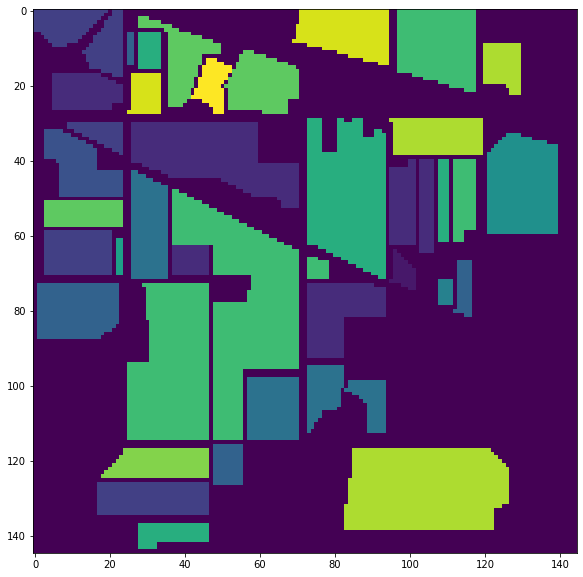

In [26]:
plt.figure(figsize=(10,10))
plt.imshow(arr_pines_gt, cmap="viridis")

In [27]:
labels = ["Unknown", "Alfalfa", "Corn-notill", "Corn-mintill", "Corn", "Grass-pasture", "Grass-trees", 
          "Grass-pasture-mowed", "Hay-windrowed", "Oats", "Soybean-notill", "Soybean-mintill", "Soybean-clean",
          "Wheat", "Woods", "Building-Grass-Tree-Drives", "Stone-Steel-Towers"]
labels

['Unknown',
 'Alfalfa',
 'Corn-notill',
 'Corn-mintill',
 'Corn',
 'Grass-pasture',
 'Grass-trees',
 'Grass-pasture-mowed',
 'Hay-windrowed',
 'Oats',
 'Soybean-notill',
 'Soybean-mintill',
 'Soybean-clean',
 'Wheat',
 'Woods',
 'Building-Grass-Tree-Drives',
 'Stone-Steel-Towers']

(9604, 955)

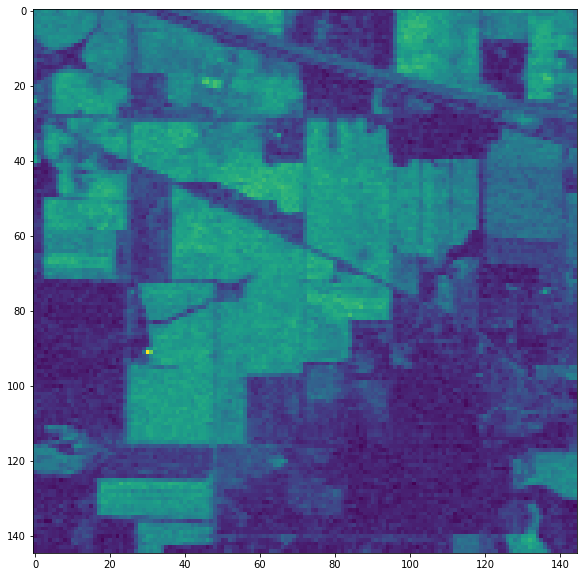

In [28]:
plt.figure(figsize=(10,10))
plt.imshow(arr_pines[:,:,150])
arr_pines.max(), arr_pines.min()

In [29]:
def normalize(arr):
    return (arr - arr.min()) / (arr.max() - arr.min())

In [30]:
print("arr_pines has", arr_pines.shape[2], "dim")
arr_pines.min(), arr_pines.max()

arr_pines has 200 dim


(955, 9604)

Les images ont été récupérées avec un capteur faisant du : 400 μm (visible/bleu) jusqu'à 2500 μm (proche infrarouge), avec une largeur de bande de 10 nm.
Wikipedia donne :
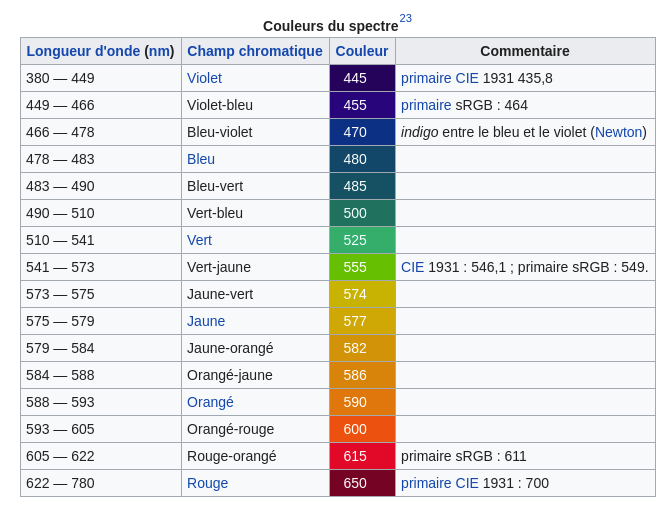

Il faut donc récupérer les longeurs d'ondes 464; 549 et 611 si l'on souhaite reconstruire l'image en RGB.

$$
\begin{align}
400 + 10 \times i &= \lambda\\
i &= \frac{\lambda - 400}{10}
\end{align}
$$

In [31]:
def find_index_wavelength(lambda_wl):
    return round((lambda_wl - 400) / 10)

In [32]:
r = find_index_wavelength(611)
g = find_index_wavelength(549)
b = find_index_wavelength(464)
rgb_pines = arr_pines[:,:,[r, g, b]]

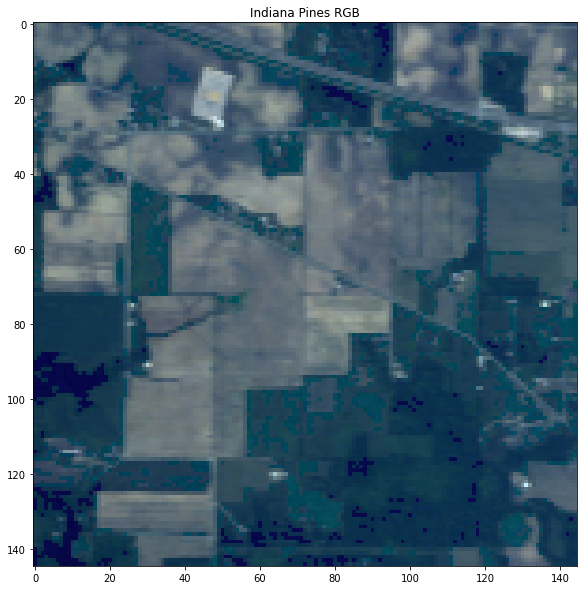

In [33]:
plt.figure(figsize=(10,10))
plt.title("Indiana Pines RGB")
plt.imshow(normalize(rgb_pines))
row,col,dim = arr_pines.shape

## Creation of train, test sets
We will first retrieve all the hyperspectral pixels and sort them according to their given class

In [143]:
from sklearn.model_selection import train_test_split
X = arr_pines.reshape((-1, dim))
y = arr_pines_gt.reshape((-1))
# X = arr_pines.copy()
# y = arr_pines_gt.copy()

In [144]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [145]:
np.round(np.unique(y_train, return_counts=True)[1] / (y_train.shape[0]) * 100)

array([51.,  0.,  7.,  4.,  1.,  2.,  4.,  0.,  2.,  0.,  5., 12.,  3.,
        1.,  6.,  2.,  0.])

In [146]:
np.round(np.unique(y_test, return_counts=True)[1] / (y_test.shape[0]) * 100)

array([52.,  0.,  7.,  3.,  1.,  2.,  3.,  0.,  3.,  0.,  4., 11.,  3.,
        1.,  6.,  2.,  0.])

In [147]:
X_train.shape, y_train.shape

((18922, 200), (18922,))

In [148]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)

DecisionTreeClassifier()

In [149]:
from sklearn.metrics import plot_confusion_matrix

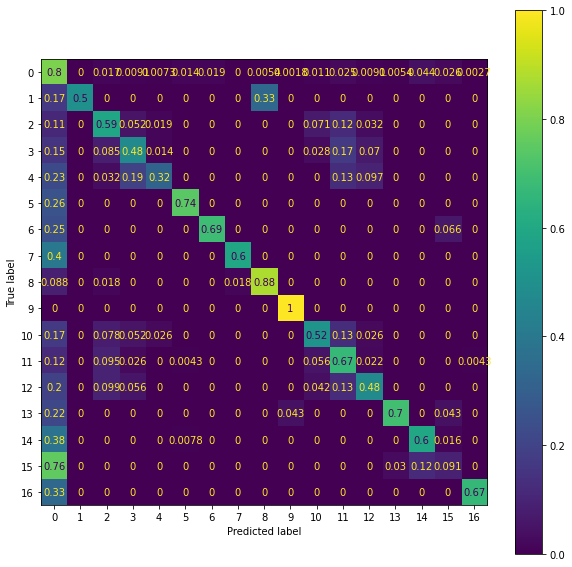

In [150]:
fig, ax = plt.subplots(figsize=(10,10))
plot_confusion_matrix(clf, X_test, y_test, ax=ax, normalize="true")

## Dimension reduction

In [45]:
arr_pines_flat = arr_pines.reshape((-1, dim))
# X.reshape((row, col, dim)).shape

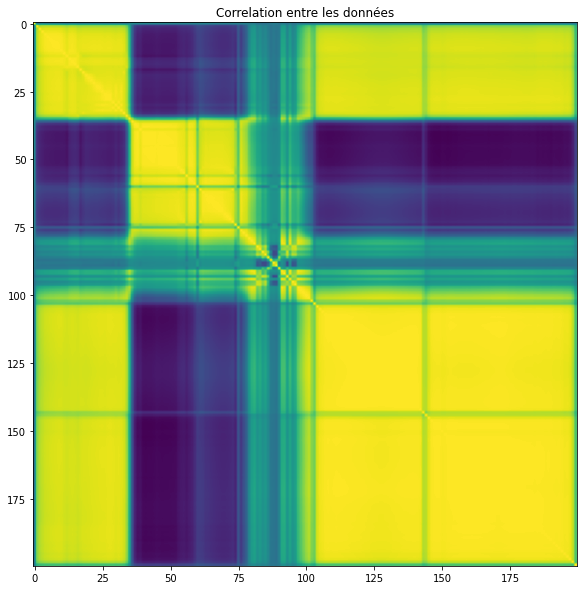

In [46]:
Sigma = np.corrcoef(arr_pines_flat,rowvar=False)
plt.figure(figsize=(10,10))
plt.title('Correlation entre les données')
plt.imshow(Sigma)

In [47]:
import sklearn.decomposition
pca_pines = sklearn.decomposition.PCA()
pca_pines.fit(arr_pines_flat)

PCA()

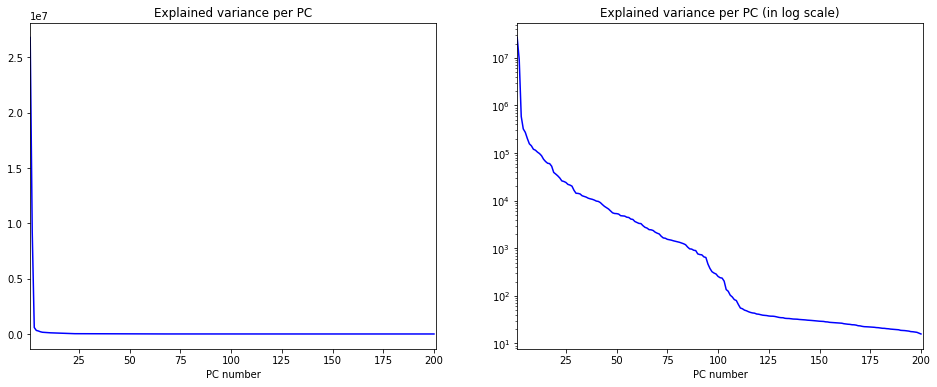

In [48]:
plt.figure(figsize=(16,6))
plt.subplot(121)
plt.title('Explained variance per PC')
plt.plot(np.arange(1,dim+1),pca_pines.explained_variance_,'b')
plt.xlabel('PC number')
plt.xlim(1,dim+1)
plt.subplot(122)
plt.title('Explained variance per PC (in log scale)')
plt.plot(np.arange(1,dim+1),pca_pines.explained_variance_,'b')
plt.xlabel('PC number')
plt.xlim(1,dim+1)
plt.yscale('log')
plt.show()

In [49]:
nb_comp = 10

In [53]:
pines_projected = pca_hsi.transform(arr_pines_flat)
pines_projected_small = pines_projected[:,:nb_comp].reshape((row,col,10))

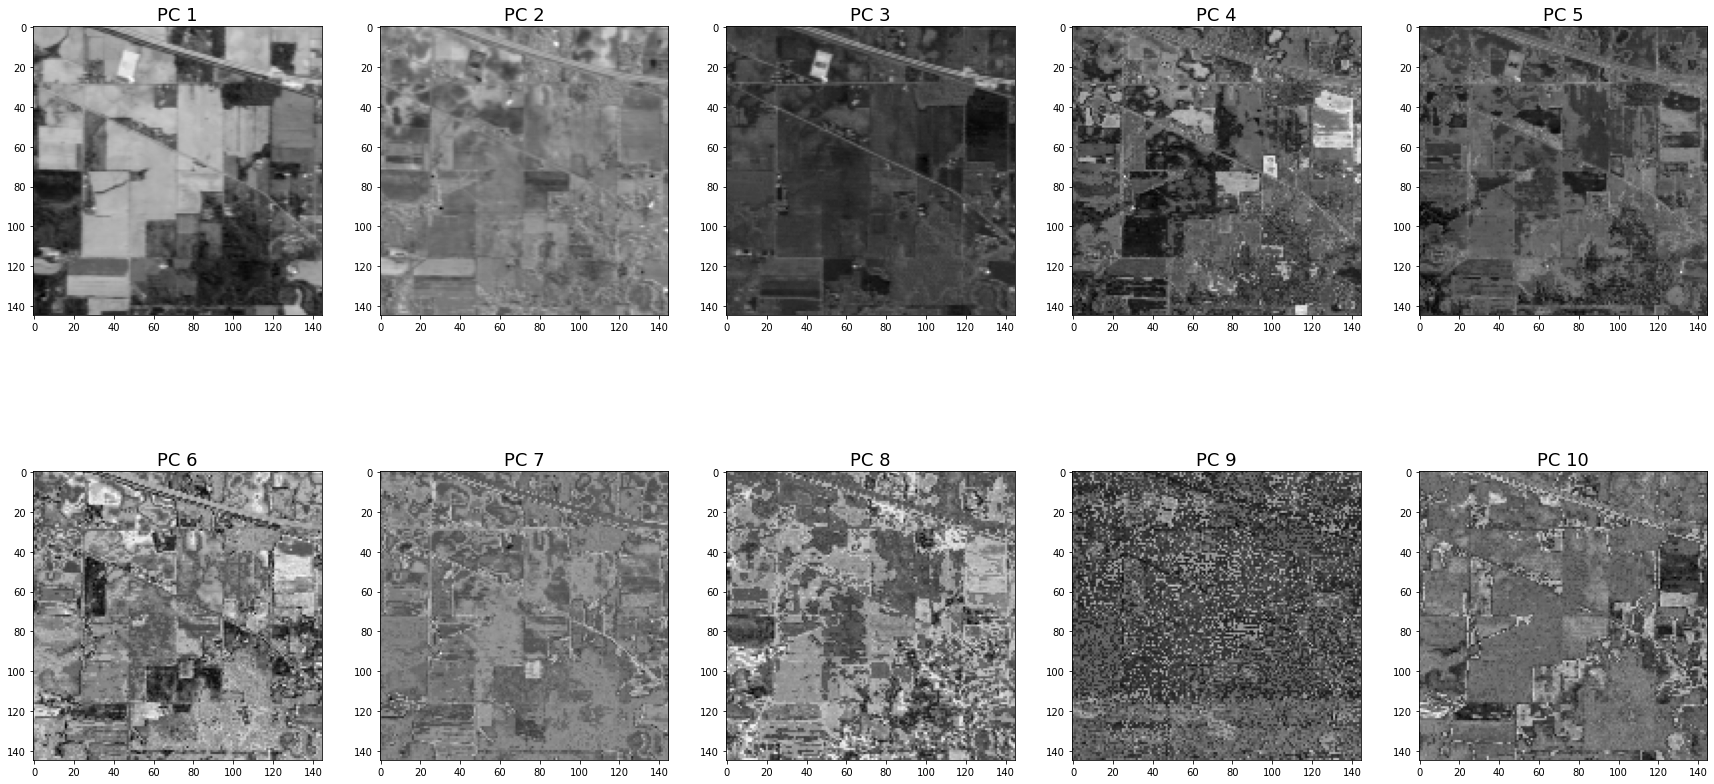

In [54]:
plt.figure(figsize=(30,15))
for i in range(nb_comp):
    plt.subplot(2,5,i+1)
    plt.title('PC %d'%(i+1),fontsize=18)
    plt.imshow(pines_projected_small[:,:,i],cmap='gray')
plt.show()

In [55]:
pines_projected_full = pines_projected.copy()
pines_projected_full[:,10:] = 0
pines_proj_back = pca_pines.inverse_transform(pines_projected_full).reshape((row,col,dim))

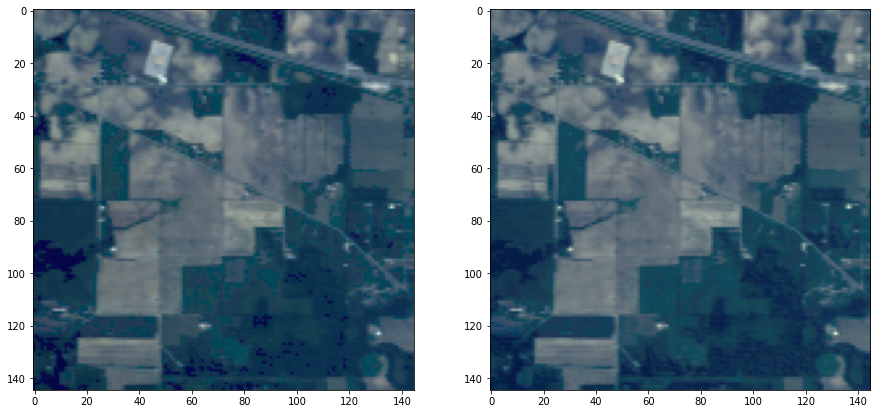

In [56]:
plt.figure(figsize=(15,10))
plt.subplot(121)
plt.imshow(normalize(rgb_pines))
plt.subplot(122)
plt.imshow(normalize(pines_proj_back[:,:,[r, g, b]]))
plt.show()

In [60]:
pines_projected_small.shape

(145, 145, 10)